In [211]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar import vecm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse

In [14]:
df = pd.read_csv('220511_monatszahlenmonatszahlen2204_verkehrsunfaelle.csv')
df

MONATSZAHL             AUSPRAEGUNG  JAHR   MONAT   WERT  \
0      Alkoholunfälle               insgesamt  2022  202201    NaN   
1      Alkoholunfälle               insgesamt  2022  202202    NaN   
2      Alkoholunfälle               insgesamt  2022  202203    NaN   
3      Alkoholunfälle               insgesamt  2022  202204    NaN   
4      Alkoholunfälle               insgesamt  2022  202205    NaN   
...               ...                     ...   ...     ...    ...   
2081  Verkehrsunfälle  Verletzte und Getötete  2000  200008  647.0   
2082  Verkehrsunfälle  Verletzte und Getötete  2000  200009  675.0   
2083  Verkehrsunfälle  Verletzte und Getötete  2000  200010  615.0   
2084  Verkehrsunfälle  Verletzte und Getötete  2000  200011  578.0   
2085  Verkehrsunfälle  Verletzte und Getötete  2000  200012  515.0   

      VORJAHRESWERT  VERAEND_VORMONAT_PROZENT  VERAEND_VORJAHRESMONAT_PROZENT  \
0              16.0                       NaN                             NaN   
1              14.0                       NaN                             NaN   
2              24.0                       NaN                             NaN   
3              16.0                       NaN                             NaN   
4              24.0                       NaN                             NaN   
...             ...                       ...                             ...   
2081            NaN                    -13.04                             NaN   
2082            NaN                      4.33                             NaN   
2083            NaN                     -8.89                             NaN   
2084            NaN                     -6.02                             NaN   
2085            NaN                    -10.90                             NaN   

      ZWOELF_MONATE_MITTELWERT  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  
...                        ...  
2081                     584.0  
2082                     594.0  
2083                     596.0  
2084                     594.0  
2085                     588.0  

[2086 rows x 9 columns]

In [15]:
# Get first 5 columns
df = df.iloc[:,:5]
df

MONATSZAHL             AUSPRAEGUNG  JAHR   MONAT   WERT
0      Alkoholunfälle               insgesamt  2022  202201    NaN
1      Alkoholunfälle               insgesamt  2022  202202    NaN
2      Alkoholunfälle               insgesamt  2022  202203    NaN
3      Alkoholunfälle               insgesamt  2022  202204    NaN
4      Alkoholunfälle               insgesamt  2022  202205    NaN
...               ...                     ...   ...     ...    ...
2081  Verkehrsunfälle  Verletzte und Getötete  2000  200008  647.0
2082  Verkehrsunfälle  Verletzte und Getötete  2000  200009  675.0
2083  Verkehrsunfälle  Verletzte und Getötete  2000  200010  615.0
2084  Verkehrsunfälle  Verletzte und Getötete  2000  200011  578.0
2085  Verkehrsunfälle  Verletzte und Getötete  2000  200012  515.0

[2086 rows x 5 columns]

In [16]:
df.dtypes

MONATSZAHL      object
AUSPRAEGUNG     object
JAHR             int64
MONAT           object
WERT           float64
dtype: object

In [17]:
# Filter data till 2020. Store 2021 onwards data in test df 
test_df = df[df['JAHR'] > 2020]
display(test_df)
df = df[df['JAHR'] <= 2020]
df

MONATSZAHL             AUSPRAEGUNG  JAHR   MONAT   WERT
0      Alkoholunfälle               insgesamt  2022  202201    NaN
1      Alkoholunfälle               insgesamt  2022  202202    NaN
2      Alkoholunfälle               insgesamt  2022  202203    NaN
3      Alkoholunfälle               insgesamt  2022  202204    NaN
4      Alkoholunfälle               insgesamt  2022  202205    NaN
...               ...                     ...   ...     ...    ...
1808  Verkehrsunfälle  Verletzte und Getötete  2021  202108  531.0
1809  Verkehrsunfälle  Verletzte und Getötete  2021  202109  678.0
1810  Verkehrsunfälle  Verletzte und Getötete  2021  202110  561.0
1811  Verkehrsunfälle  Verletzte und Getötete  2021  202111  430.0
1812  Verkehrsunfälle  Verletzte und Getötete  2021  202112  340.0

[175 rows x 5 columns]

MONATSZAHL             AUSPRAEGUNG  JAHR   MONAT   WERT
25     Alkoholunfälle               insgesamt  2020   Summe  430.0
26     Alkoholunfälle               insgesamt  2020  202001   28.0
27     Alkoholunfälle               insgesamt  2020  202002   40.0
28     Alkoholunfälle               insgesamt  2020  202003   27.0
29     Alkoholunfälle               insgesamt  2020  202004   26.0
...               ...                     ...   ...     ...    ...
2081  Verkehrsunfälle  Verletzte und Getötete  2000  200008  647.0
2082  Verkehrsunfälle  Verletzte und Getötete  2000  200009  675.0
2083  Verkehrsunfälle  Verletzte und Getötete  2000  200010  615.0
2084  Verkehrsunfälle  Verletzte und Getötete  2000  200011  578.0
2085  Verkehrsunfälle  Verletzte und Getötete  2000  200012  515.0

[1911 rows x 5 columns]

In [218]:
# Changing month to number
def preprocess_df(input_df):
    df_year = input_df[input_df['MONAT'] == 'Summe']

    df_month = input_df[input_df['MONAT'] != 'Summe']
    df_month['MONAT'] = df_month['MONAT'].apply(lambda x: int(str(x)[-2:]))
    
    return df_year, df_month

df_year, df_month = preprocess_df(df)
display(df_year)
display(df_month)
test_df_year, test_df_month = preprocess_df(test_df)
display(test_df_year)
display(test_df_month)

/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/2021754605.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['MONAT'] = df_month['MONAT'].apply(lambda x: int(str(x)[-2:]))


MONATSZAHL             AUSPRAEGUNG  JAHR  MONAT    WERT
25     Alkoholunfälle               insgesamt  2020  Summe   430.0
38     Alkoholunfälle               insgesamt  2019  Summe   434.0
51     Alkoholunfälle               insgesamt  2018  Summe   398.0
64     Alkoholunfälle               insgesamt  2017  Summe   409.0
77     Alkoholunfälle               insgesamt  2016  Summe   301.0
...               ...                     ...   ...    ...     ...
2021  Verkehrsunfälle  Verletzte und Getötete  2004  Summe  6219.0
2034  Verkehrsunfälle  Verletzte und Getötete  2003  Summe  6365.0
2047  Verkehrsunfälle  Verletzte und Getötete  2002  Summe  7026.0
2060  Verkehrsunfälle  Verletzte und Getötete  2001  Summe  7452.0
2073  Verkehrsunfälle  Verletzte und Getötete  2000  Summe  7053.0

[147 rows x 5 columns]

MONATSZAHL             AUSPRAEGUNG  JAHR  MONAT   WERT
26     Alkoholunfälle               insgesamt  2020      1   28.0
27     Alkoholunfälle               insgesamt  2020      2   40.0
28     Alkoholunfälle               insgesamt  2020      3   27.0
29     Alkoholunfälle               insgesamt  2020      4   26.0
30     Alkoholunfälle               insgesamt  2020      5   40.0
...               ...                     ...   ...    ...    ...
2081  Verkehrsunfälle  Verletzte und Getötete  2000      8  647.0
2082  Verkehrsunfälle  Verletzte und Getötete  2000      9  675.0
2083  Verkehrsunfälle  Verletzte und Getötete  2000     10  615.0
2084  Verkehrsunfälle  Verletzte und Getötete  2000     11  578.0
2085  Verkehrsunfälle  Verletzte und Getötete  2000     12  515.0

[1764 rows x 5 columns]

/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/2021754605.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['MONAT'] = df_month['MONAT'].apply(lambda x: int(str(x)[-2:]))


MONATSZAHL             AUSPRAEGUNG  JAHR  MONAT     WERT
12     Alkoholunfälle               insgesamt  2021  Summe    383.0
310    Alkoholunfälle  Verletzte und Getötete  2021  Summe    214.0
608     Fluchtunfälle               insgesamt  2021  Summe   9879.0
906     Fluchtunfälle  Verletzte und Getötete  2021  Summe    556.0
1204  Verkehrsunfälle               insgesamt  2021  Summe  38015.0
1502  Verkehrsunfälle     mit Personenschäden  2021  Summe   4825.0
1800  Verkehrsunfälle  Verletzte und Getötete  2021  Summe   5560.0

MONATSZAHL             AUSPRAEGUNG  JAHR  MONAT   WERT
0      Alkoholunfälle               insgesamt  2022      1    NaN
1      Alkoholunfälle               insgesamt  2022      2    NaN
2      Alkoholunfälle               insgesamt  2022      3    NaN
3      Alkoholunfälle               insgesamt  2022      4    NaN
4      Alkoholunfälle               insgesamt  2022      5    NaN
...               ...                     ...   ...    ...    ...
1808  Verkehrsunfälle  Verletzte und Getötete  2021      8  531.0
1809  Verkehrsunfälle  Verletzte und Getötete  2021      9  678.0
1810  Verkehrsunfälle  Verletzte und Getötete  2021     10  561.0
1811  Verkehrsunfälle  Verletzte und Getötete  2021     11  430.0
1812  Verkehrsunfälle  Verletzte und Getötete  2021     12  340.0

[168 rows x 5 columns]

In [219]:
# Data Transformation
def transform_df(input_df):
    df_new = pd.DataFrame()
    temp = input_df.copy()
    temp['MONAT'] = temp['MONAT'].apply(lambda x: '0'+str(x) if x<10 else str(x))
    temp['Date'] = temp.apply(lambda x: str(x['JAHR']) + str(x['MONAT']) + '01', axis = 1)
    temp['Date'] = pd.to_datetime(temp['Date'])

    for cat in df_month['MONATSZAHL'].unique():
        for acc in temp[temp['MONATSZAHL'] == cat]['AUSPRAEGUNG'].unique():
    #         print(cat, 'and', acc)
            temp2=temp[(temp['MONATSZAHL'] == cat) & (temp['AUSPRAEGUNG'] == acc)]
            temp2 = temp2.dropna()
            col = cat + ' and ' + acc
            temp_df = pd.DataFrame()
            temp_df['Date'] = temp2['Date']
            temp_df[col] = temp2['WERT']

            if len(df_new.columns) == 0:
                df_new = temp_df.copy()
            else:
                df_new = pd.merge(df_new,temp_df, on='Date')

    df_new = df_new.set_index('Date')
    df_new.index = df_new.index.to_period('M')
    df_new = df_new.sort_index()
    return df_new

df_new = transform_df(df_month)
display(df_new)
test_df_new = transform_df(test_df_month)
display(test_df_new)

Alkoholunfälle and insgesamt  \
Date                                    
2000-01                          78.0   
2000-02                          53.0   
2000-03                          73.0   
2000-04                          78.0   
2000-05                          96.0   
...                               ...   
2020-08                          46.0   
2020-09                          46.0   
2020-10                          34.0   
2020-11                          23.0   
2020-12                          13.0   

         Alkoholunfälle and Verletzte und Getötete  \
Date                                                 
2000-01                                       37.0   
2000-02                                       19.0   
2000-03                                       18.0   
2000-04                                       26.0   
2000-05                                       44.0   
...                                            ...   
2020-08                                       29.0   
2020-09                                       24.0   
2020-10                                       20.0   
2020-11                                       11.0   
2020-12                                        9.0   

         Fluchtunfälle and insgesamt  \
Date                                   
2000-01                        835.0   
2000-02                        890.0   
2000-03                        974.0   
2000-04                        834.0   
2000-05                       1086.0   
...                              ...   
2020-08                        735.0   
2020-09                        948.0   
2020-10                        997.0   
2020-11                        864.0   
2020-12                        694.0   

         Fluchtunfälle and Verletzte und Getötete  \
Date                                                
2000-01                                      34.0   
2000-02                                      35.0   
2000-03                                      48.0   
2000-04                                      57.0   
2000-05                                      69.0   
...                                           ...   
2020-08                                      36.0   
2020-09                                      49.0   
2020-10                                      50.0   
2020-11                                      27.0   
2020-12                                      33.0   

         Verkehrsunfälle and insgesamt  \
Date                                     
2000-01                         3448.0   
2000-02                         3181.0   
2000-03                         3783.0   
2000-04                         3317.0   
2000-05                         4123.0   
...                                ...   
2020-08                         3007.0   
2020-09                         3659.0   
2020-10                         3867.0   
2020-11                         3150.0   
2020-12                         2661.0   

         Verkehrsunfälle and mit Personenschäden  \
Date                                               
2000-01                                    321.0   
2000-02                                    329.0   
2000-03                                    414.0   
2000-04                                    441.0   
2000-05                                    568.0   
...                                          ...   
2020-08                                    487.0   
2020-09                                    555.0   
2020-10                                    489.0   
2020-11                                    297.0   
2020-12                                    270.0   

         Verkehrsunfälle and Verletzte und Getötete  
Date                                                 
2000-01                                       434.0  
2000-02                                       419.0  
2000-03                                       509.0  
2000-04                                       557.0  
2000-05      

Alkoholunfälle and insgesamt  \
Date                                    
2021-01                          16.0   
2021-02                          14.0   
2021-03                          24.0   
2021-04                          16.0   
2021-05                          24.0   
2021-06                          48.0   
2021-07                          44.0   
2021-08                          46.0   
2021-09                          54.0   
2021-10                          43.0   
2021-11                          33.0   
2021-12                          21.0   

         Alkoholunfälle and Verletzte und Getötete  \
Date                                                 
2021-01                                        5.0   
2021-02                                        9.0   
2021-03                                        6.0   
2021-04                                        6.0   
2021-05                                       13.0   
2021-06                                       39.0   
2021-07                                       27.0   
2021-08                                       24.0   
2021-09                                       36.0   
2021-10                                       27.0   
2021-11                                       15.0   
2021-12                                        7.0   

         Fluchtunfälle and insgesamt  \
Date                                   
2021-01                        521.0   
2021-02                        602.0   
2021-03                        801.0   
2021-04                        716.0   
2021-05                        865.0   
2021-06                        991.0   
2021-07                       1027.0   
2021-08                        715.0   
2021-09                        951.0   
2021-10                       1053.0   
2021-11                        849.0   
2021-12                        788.0   

         Fluchtunfälle and Verletzte und Getötete  \
Date                                                
2021-01                                       8.0   
2021-02                                      31.0   
2021-03                                      30.0   
2021-04                                      40.0   
2021-05                                      45.0   
2021-06                                      82.0   
2021-07                                      77.0   
2021-08                                      41.0   
2021-09                                      78.0   
2021-10                                      52.0   
2021-11                                      55.0   
2021-12                                      17.0   

         Verkehrsunfälle and insgesamt  \
Date                                     
2021-01                         2153.0   
2021-02                         2253.0   
2021-03                         3135.0   
2021-04                         2904.0   
2021-05                         3197.0   
2021-06                         3791.0   
2021-07                         3908.0   
2021-08                         2857.0   
2021-09                         3651.0   
2021-10                         3861.0   
2021-11                         3308.0   
2021-12                         2997.0   

         Verkehrsunfälle and mit Personenschäden  \
Date                                               
2021-01                                    157.0   
2021-02                                    220.0   
2021-03                                    290.0   
2021-04                                    332.0   
2021-05                                    370.0   
2021-06                                    644.0   
2021-07                                    625.0   
2021-08                                    449.0   
2021-09                                    594.0   
2021-10                                    492.0   
2021-11                                    368.0   
2021-12                                    284.0   

         Verkehrsunfälle and Verletzte und Getötete  
D

# EDA
## Pandas Profiling Analysis

In [9]:
# Pandas Profiling Report
profile = pp.ProfileReport(df)
profile

Render HTML: 100%|████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


In [19]:
profile_year = pp.ProfileReport(df_year)
profile_year

Render HTML: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


In [20]:
profile_month = pp.ProfileReport(df_month)
profile_month

Render HTML: 100%|████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


## Categorical Variable Analysis
Correlation heatmap also interesting: Check output of Pandas profiling `Phik` correlation

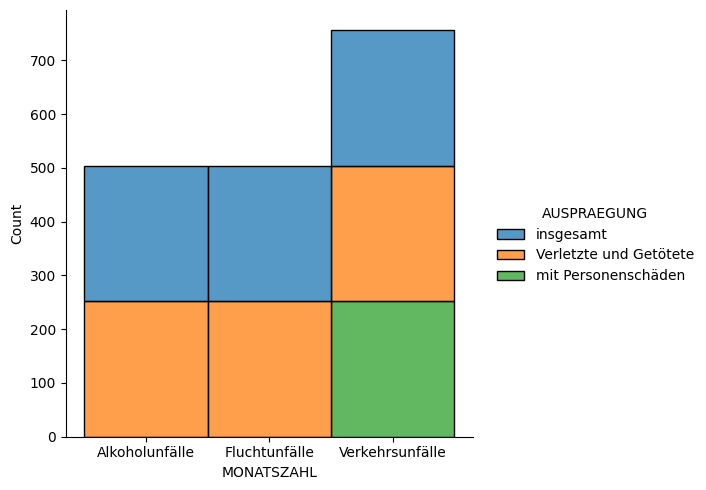

In [97]:
# Value Counts using stacked bar plots
sns.displot(data=df_month, x='MONATSZAHL', hue='AUSPRAEGUNG', multiple='stack')
plt.show()

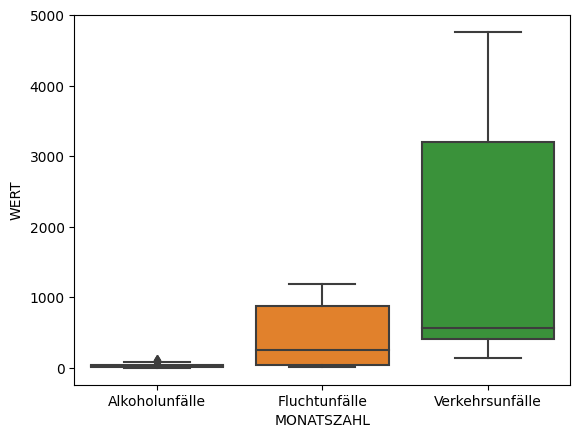

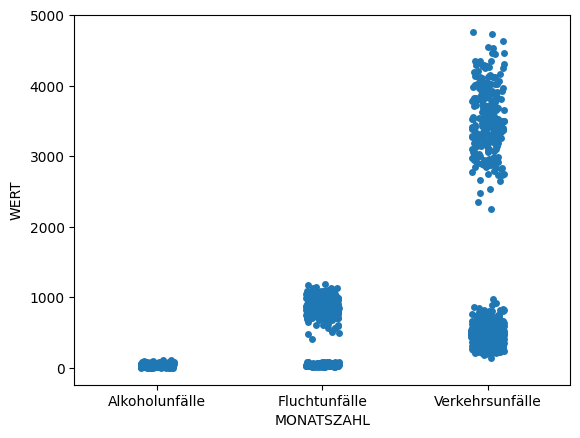

'\nInferences from Strip Plot:-\n1. Escape and Traffic Accidents making 2 clusters. \nNeed to go into detail what factor/variable in causing this clustering\n'

In [51]:
# Box Plot of values category wise: Primitive
sns.boxplot(data=df_month, x='MONATSZAHL', y='WERT')
plt.show()

'''
Inferences from Box Plot:- 
1. Distribution variation different for every Category (Order: Alcohol<Escape<Traffic)
2. Increasing Order of Means same as above
''' 

# Strip Plot of values category wise: Gives better understanding
sns.stripplot(data=df_month, x='MONATSZAHL', y='WERT')
plt.show()

'''
Inferences from Strip Plot:-
1. Escape and Traffic Accidents making 2 clusters. 
Need to go into detail what factor/variable in causing this clustering
'''

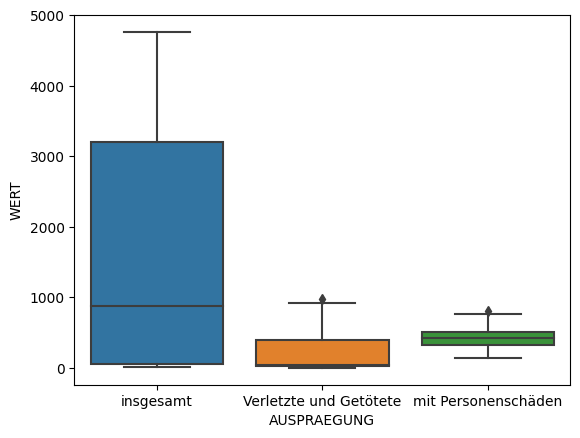

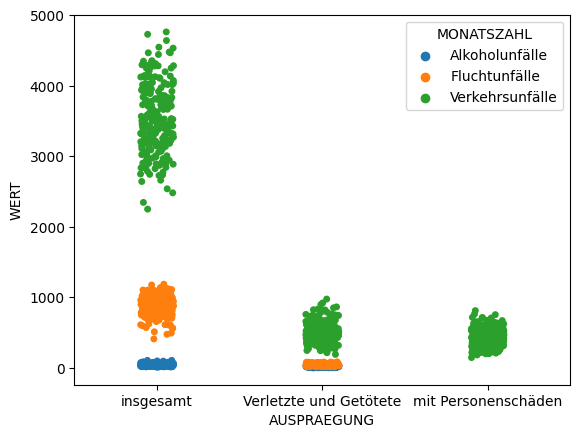

'\nInferences:-\n1. Distribution variation similar for Injured & Killed, Personal Injury. Total Distribution more variation.\n2. Increasing Order of Means: Injured & Killed < Personal Injury < Total\n'

In [52]:
# Box Plot of values accident-type wise
sns.boxplot(data=df_month, x='AUSPRAEGUNG', y='WERT')
plt.show()

'''
Inferences:-
1. Distribution variation similar for Injured & Killed, Personal Injury. Total Distribution more variation.
2. Increasing Order of Means: Injured & Killed < Personal Injury < Total
'''

# Strip Plot of values accident-type wise
sns.stripplot(data=df_month, x='AUSPRAEGUNG', y='WERT', hue = 'MONATSZAHL')
plt.show()

'''
Inferences:-
1. 'Total' accident-type has visibly separate clusters denoting each Category.
2. For 'Injured & Killed', Alcohol and Escape Accident clusters overlapping.
3. 'Personal Injury' has only one cluster: Traffic Accident Category.
'''

## Time-Series Analysis

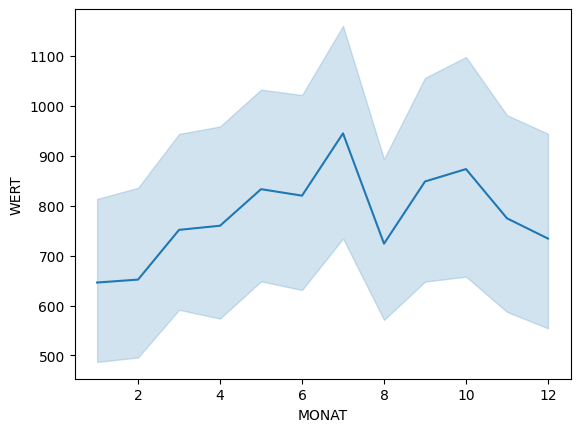

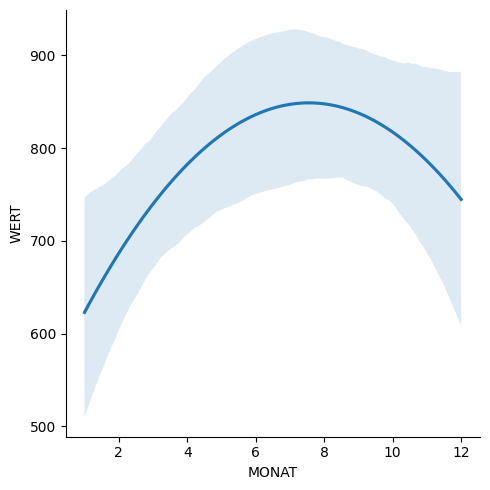

In [86]:
# Month-Wise Distribution: Line/Regression Plot
sns.lineplot(data=df_month, x='MONAT', y='WERT')
plt.show()

'''
Inference:-
1. Stable Increasing trend for more than half a year (first half)
2. Irregular decreasing trend after July(7)
Might help making a regression plot here that prevents overfitting
'''

sns.lmplot(data=df_month, x='MONAT', y='WERT', order=2, scatter=False)
plt.show()

'''
Inferences:-
1. Regression Plot of order 2 shows a parabolic shape peaking around July as we expected.
'''

Alkoholunfälle and insgesamt


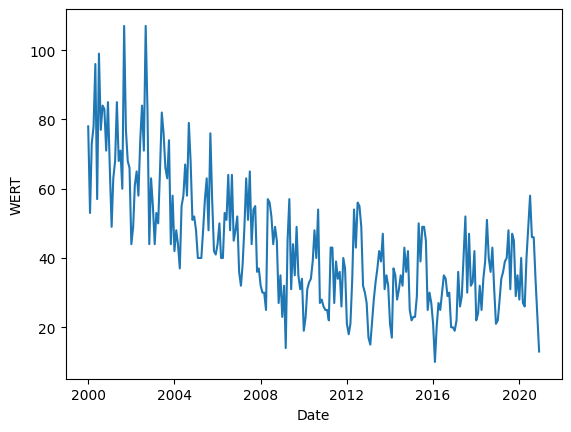

Alkoholunfälle and Verletzte und Getötete


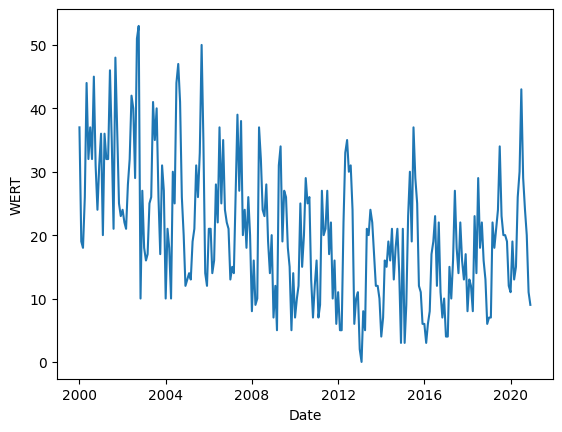

Fluchtunfälle and insgesamt


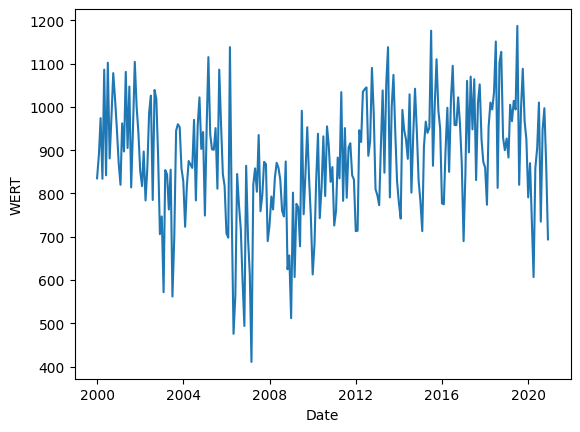

Fluchtunfälle and Verletzte und Getötete


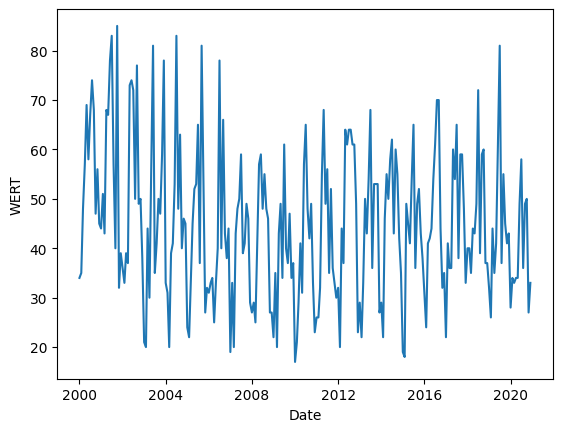

Verkehrsunfälle and insgesamt


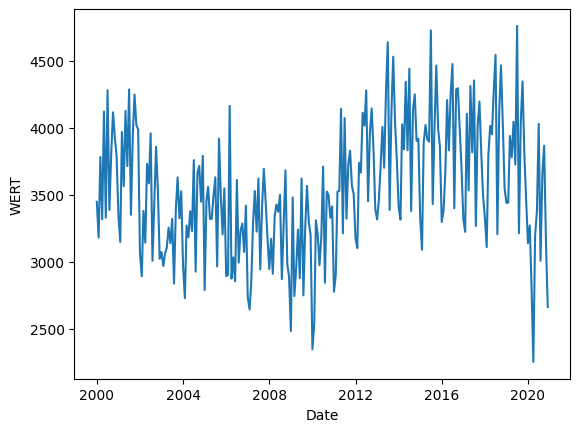

Verkehrsunfälle and mit Personenschäden


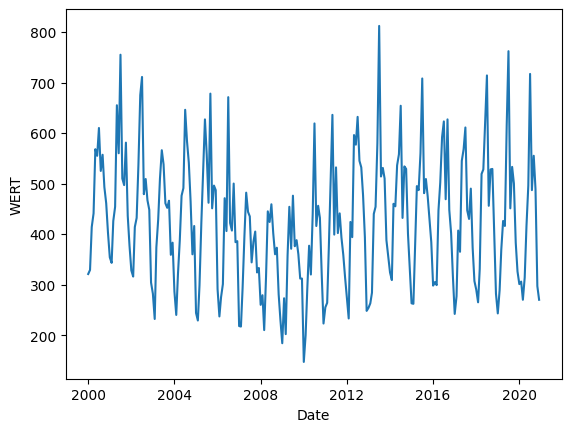

Verkehrsunfälle and Verletzte und Getötete


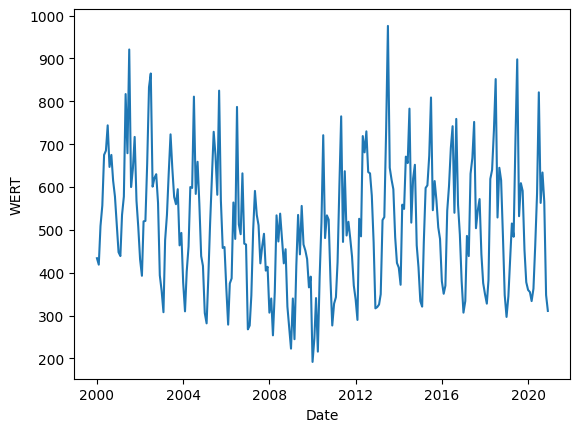

In [106]:
# Time-Series Line plot for every Category & Accident-Type pair
temp = df_month.copy()
temp['MONAT'] = temp['MONAT'].apply(lambda x: '0'+str(x) if x<10 else str(x))
temp['Date'] = temp.apply(lambda x: str(x['JAHR']) + str(x['MONAT']) + '01', axis = 1)
temp['Date'] = pd.to_datetime(temp['Date'])

for cat in df_month['MONATSZAHL'].unique():
    for acc in temp[temp['MONATSZAHL'] == cat]['AUSPRAEGUNG'].unique():
        print(cat, 'and', acc)
        temp2=temp[(temp['MONATSZAHL'] == cat) & (temp['AUSPRAEGUNG'] == acc)]
#         print(temp2.shape) # (252,6)
        sns.lineplot(data = temp2, x='Date', y='WERT')
        plt.show()
#         temp2['Date'] = pd.to_numeric(temp2['Date'])
#         sns.lmplot(data = temp2, x='Date', y='WERT', x_bins=5)
#         plt.show()

In [172]:
# Check if the Time-Series are stationary or not
temp = df_month.copy()
temp['MONAT'] = temp['MONAT'].apply(lambda x: '0'+str(x) if x<10 else str(x))
temp['Date'] = temp.apply(lambda x: str(x['JAHR']) + str(x['MONAT']) + '01', axis = 1)
temp['Date'] = pd.to_datetime(temp['Date'])

temp_log = temp.copy()
temp_log['WERT'] = np.log(temp_log['WERT'])
temp_log_diff = temp_log.copy()
temp_log_diff['WERT'] = temp_log_diff['WERT'].diff()

def augmented_dickey_fuller_statistics(time_series):
    try:
        result = adfuller(time_series['WERT'].values)
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
    except:
        time_series['WERT'] = time_series['WERT'].replace(-np.inf, 0)
        time_series['WERT'] = time_series['WERT'].replace(np.inf, 0)
        augmented_dickey_fuller_statistics(time_series)
        

for cat in df_month['MONATSZAHL'].unique():
    for acc in temp[temp['MONATSZAHL'] == cat]['AUSPRAEGUNG'].unique():
        print(cat, 'and', acc)
        temp2=temp_log[(temp_log['MONATSZAHL'] == cat) & (temp_log['AUSPRAEGUNG'] == acc)]
        temp3=temp_log_diff[(temp_log_diff['MONATSZAHL'] == cat) & (temp_log_diff['AUSPRAEGUNG'] == acc)]
        
        temp2.dropna(inplace = True)
        temp3.dropna(inplace = True)
        
        augmented_dickey_fuller_statistics(temp2)
        print('1st Order Difference')
        augmented_dickey_fuller_statistics(temp3)
        print()

'''
Inferences:-
1. None of the Time-Series are stationary since the p-value is coming >0.05
2. They all have stationary differences
Now we can check for cointegrating relationships (Note: Non-Stationary series is said to be cointegrated if there 
exists atleast one linear combination of these variables that is stationary)
'''

/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/682337221.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2.dropna(inplace = True)
/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/682337221.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp3.dropna(inplace = True)
/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/682337221.py:29: SettingWithCopyWarning: 
A value is trying to be set on a

Alkoholunfälle and insgesamt
ADF Statistic: 0.90354663150075
p-value: 0.9931364367109975
1st Order Difference
ADF Statistic: -7.433747189748192
p-value: 6.261716838143453e-11

Alkoholunfälle and Verletzte und Getötete
ADF Statistic: -0.5150978798831161
p-value: 0.8890364200602097
1st Order Difference
ADF Statistic: -4.831472911429865
p-value: 4.732735423553238e-05

Fluchtunfälle and insgesamt
ADF Statistic: -1.877586942679365
p-value: 0.34267725378944963
1st Order Difference
ADF Statistic: -9.993839907028521
p-value: 1.9638808385886312e-17

Fluchtunfälle and Verletzte und Getötete
ADF Statistic: -1.2911054698543771
p-value: 0.6332316840310178
1st Order Difference
ADF Statistic: -12.901925533092736
p-value: 4.2303704427065584e-24

Verkehrsunfälle and insgesamt
ADF Statistic: -1.3992117551289582
p-value: 0.5826539546268907
1st Order Difference
ADF Statistic: -6.03102494676217
p-value: 1.4179027851282848e-07

Verkehrsunfälle and mit Personenschäden
ADF Statistic: -0.9723006732026998
p-val

'\nInferences:-\n1. None of the Time-Series are stationary since the p-value is coming >0.05\n2. They all have stationary differences\nNow we can check for cointegrating relationships (Note: Non-Stationary series is said to be cointegrated if there \nexists atleast one linear combination of these variables that is stationary)\n'

In [162]:
# Johansen Cointegration Test
temp = df_new.copy()
temp_log = np.log(temp)

temp_log = temp_log.replace(-np.inf, 0)
temp_log = temp_log.replace(np.inf, 0)

vec_rank1 = vecm.select_coint_rank(temp_log, det_order = 0, k_ar_diff = 1, method = 'trace', signif = 0.05)
print(vec_rank1.summary())
print()
vec_rank2 = vecm.select_coint_rank(temp_log, det_order = 1, k_ar_diff = 1, method = 'trace', signif = 0.05)
print(vec_rank2.summary())

'''
Inferences:-
1. Since trace statistic > critical value for all rows in the summary, we can reject the null hypothesis.
Thus, cointegration relationships exist.
'''

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   7          497.8          125.6
  1   7          379.0          95.75
  2   7          276.7          69.82
  3   7          189.2          47.85
  4   7          112.7          29.80
  5   7          56.49          15.49
  6   7          14.86          3.841
-------------------------------------

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   7          557.7          139.3
  1   7          438.3          107.3
  2   7          335.0          79.34
  3   7          244.6          55.25
  4   7          165.2          35.01
  5   7          91.78          18.40
  6   7          39.43          3.841
-------------------------------------


Alkoholunfälle and insgesamt


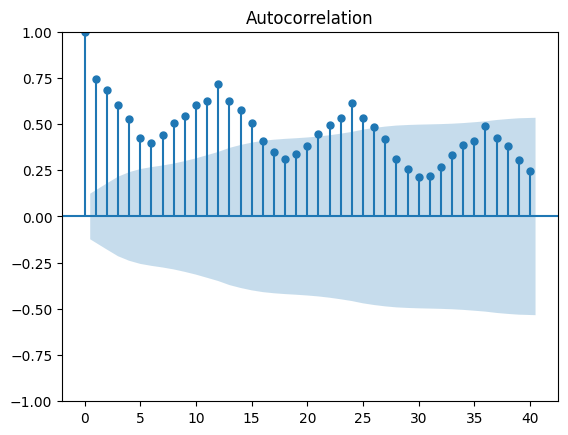

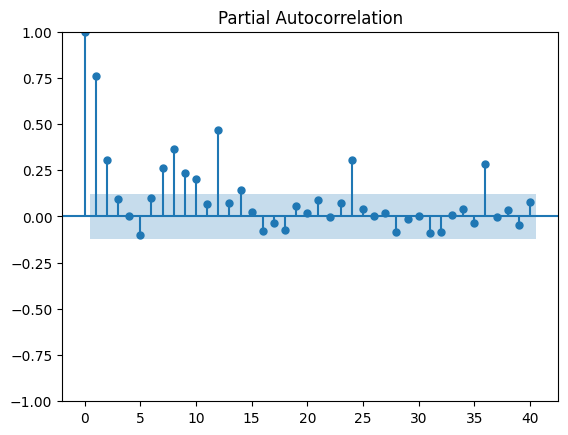

Alkoholunfälle and Verletzte und Getötete


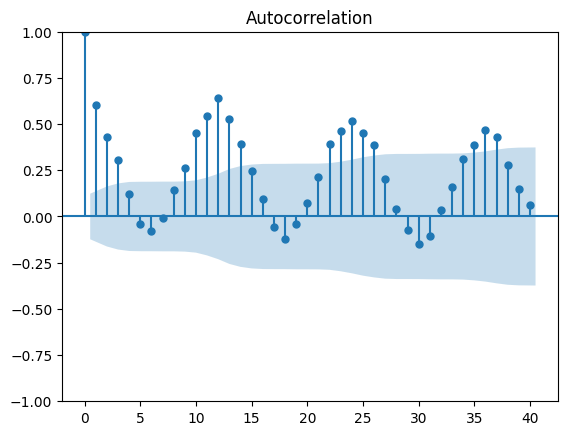

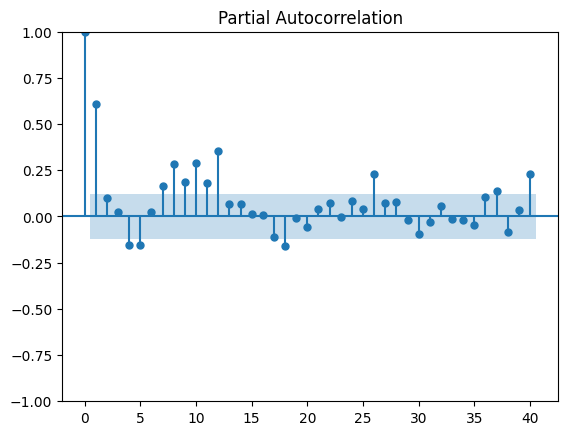

Fluchtunfälle and insgesamt


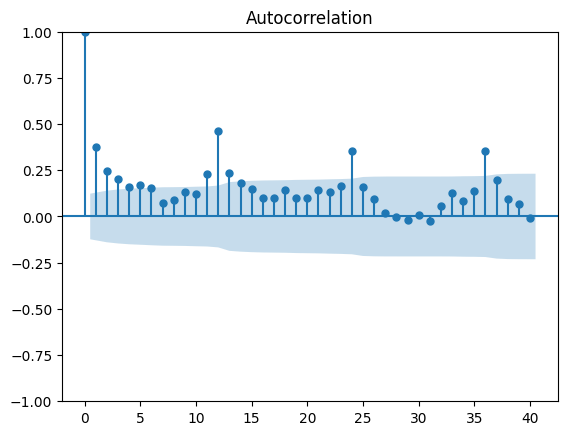

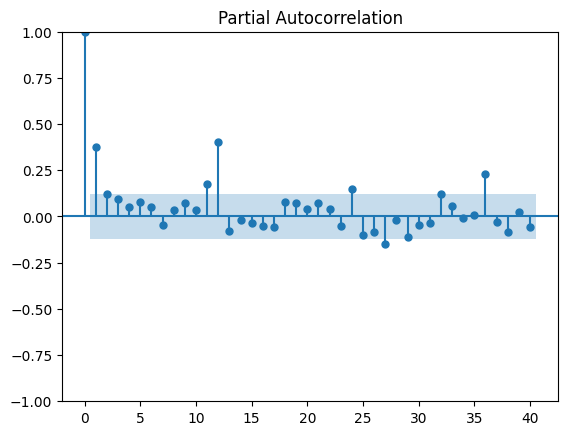

Fluchtunfälle and Verletzte und Getötete


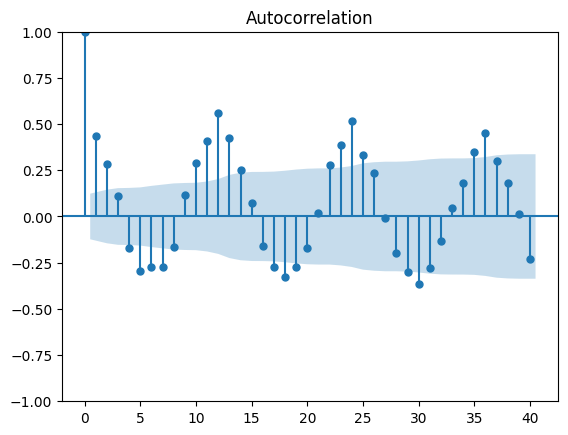

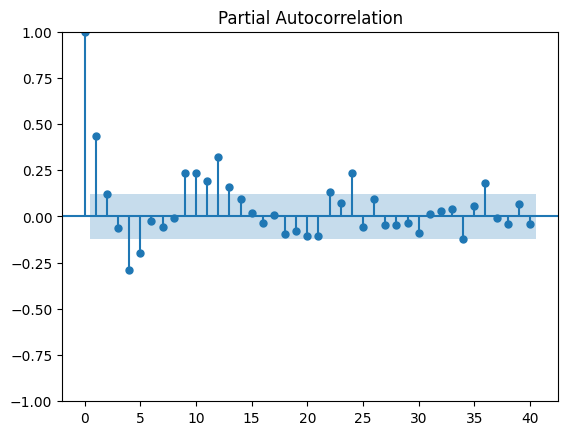

Verkehrsunfälle and insgesamt


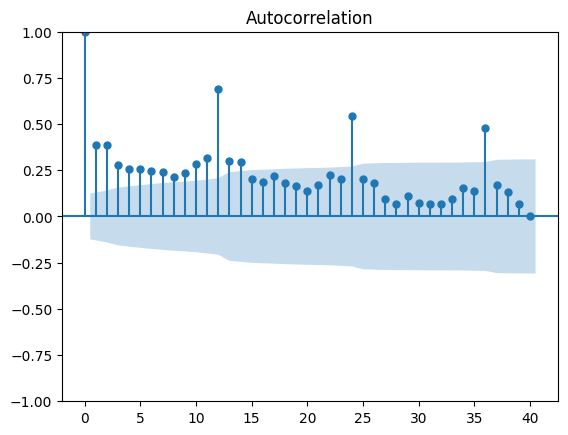

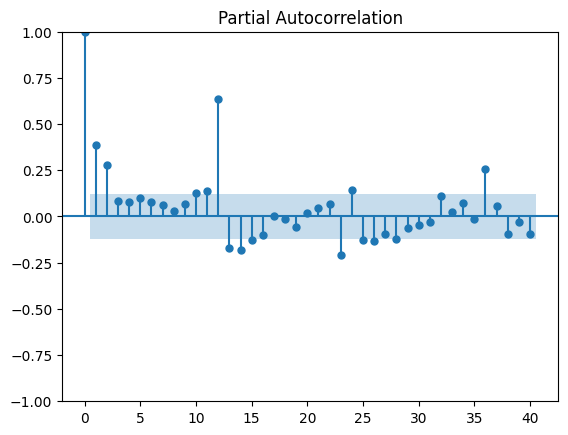

Verkehrsunfälle and mit Personenschäden


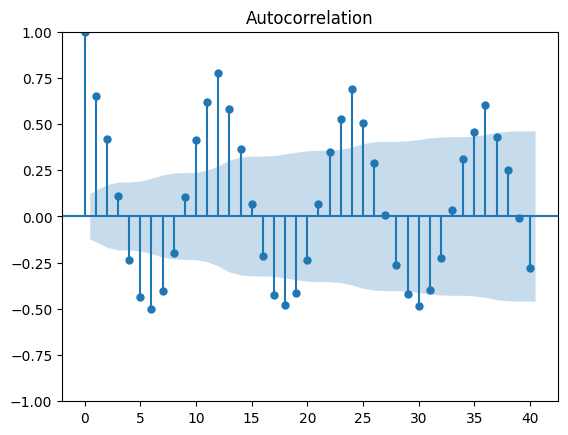

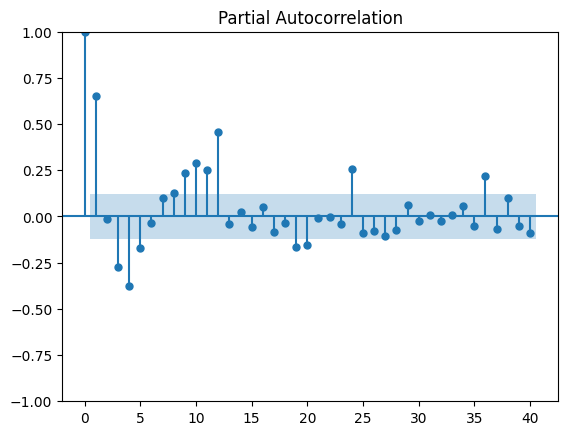

Verkehrsunfälle and Verletzte und Getötete


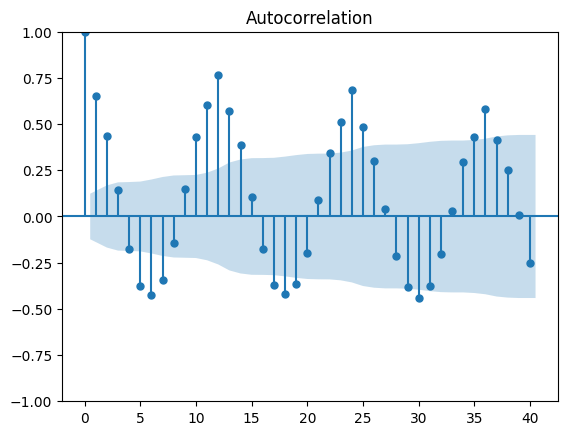

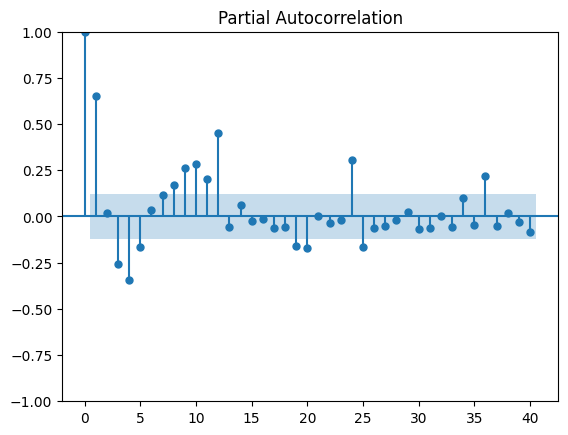

'\nInferences:-\n1. At an average, our Auto-Regression model should be of window somewhere between 10-15 lags. \nThat is when the correlation effect starts to get lesser and lesser as the lags increase.\n'

In [166]:
# Plot Partial Auto-Correlation Function in Time-Series
temp = df_month.copy()
temp['MONAT'] = temp['MONAT'].apply(lambda x: '0'+str(x) if x<10 else str(x))
temp['Date'] = temp.apply(lambda x: str(x['JAHR']) + str(x['MONAT']) + '01', axis = 1)
temp['Date'] = pd.to_datetime(temp['Date'])

for cat in df_month['MONATSZAHL'].unique():
    for acc in temp[temp['MONATSZAHL'] == cat]['AUSPRAEGUNG'].unique():
        print(cat, 'and', acc)
        temp2=temp[(temp['MONATSZAHL'] == cat) & (temp['AUSPRAEGUNG'] == acc)]
        plot_acf(temp2['WERT'].values.squeeze(), lags=40)
        plot_pacf(temp2['WERT'].values.squeeze(), lags=40, method='ols')
        plt.show()

'''
Inferences:-
1. ACF tails off, PACF cuts off.
2. At an average, our Auto-Regression model should be of window somewhere between 10-15 lags. 
That is when the correlation effect starts to get lesser and lesser as the lags increase.
'''

Alkoholunfälle and insgesamt


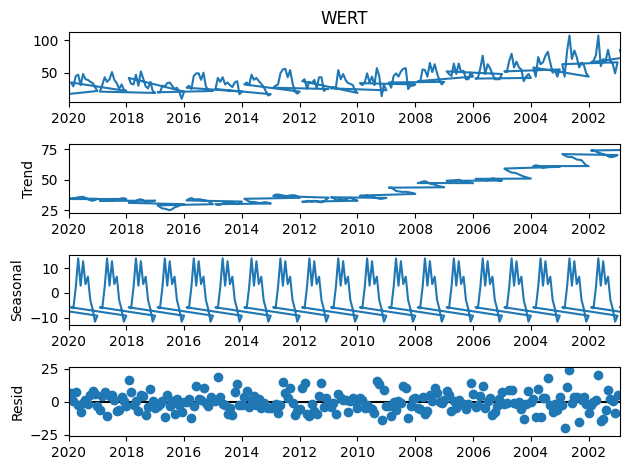

Alkoholunfälle and Verletzte und Getötete


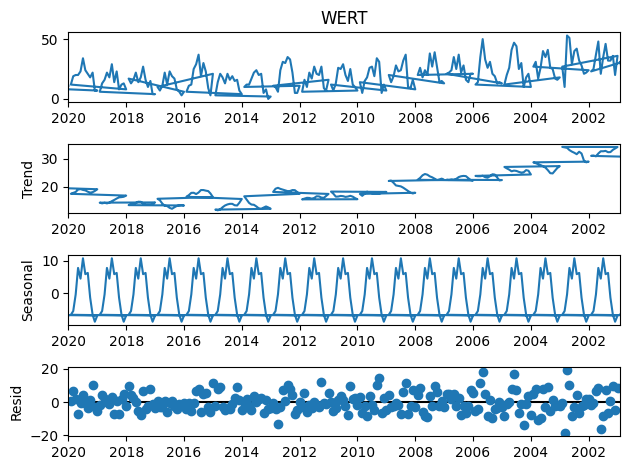

Fluchtunfälle and insgesamt


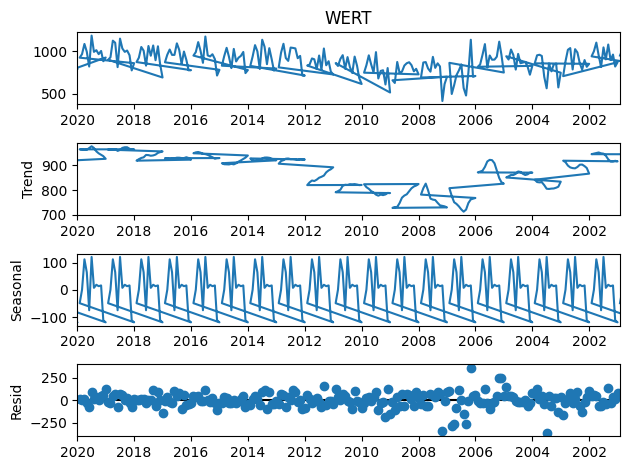

Fluchtunfälle and Verletzte und Getötete


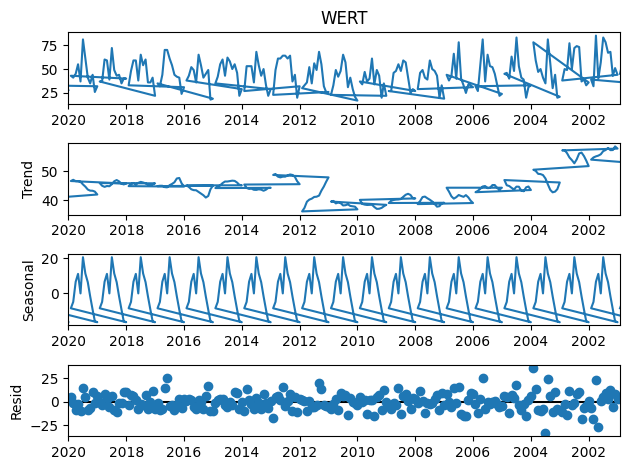

Verkehrsunfälle and insgesamt


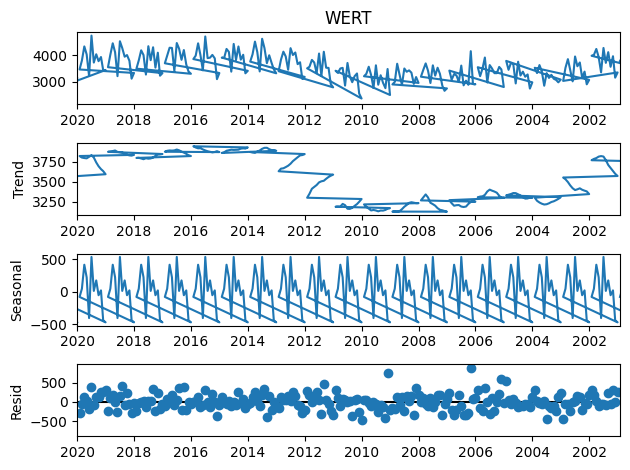

Verkehrsunfälle and mit Personenschäden


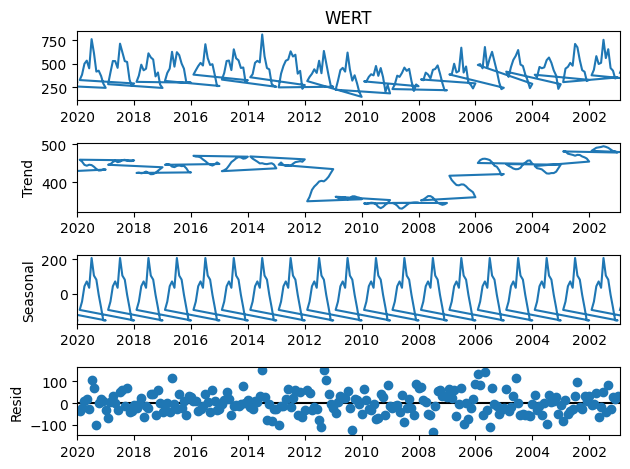

Verkehrsunfälle and Verletzte und Getötete


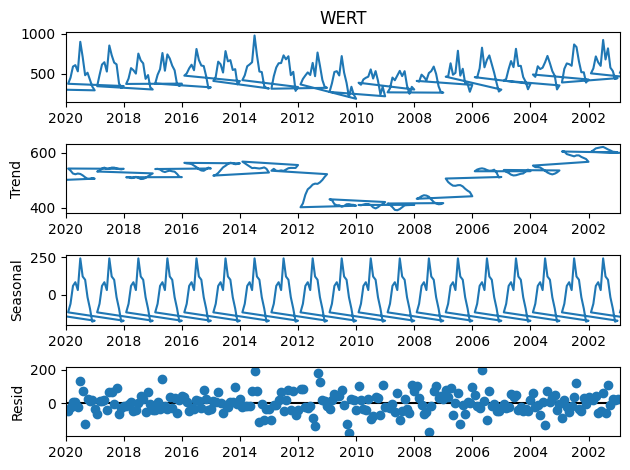

In [119]:
# Trend and Seasonality check
temp = df_month.copy()
temp['MONAT'] = temp['MONAT'].apply(lambda x: '0'+str(x) if x<10 else str(x))
temp['Date'] = temp.apply(lambda x: str(x['JAHR']) + str(x['MONAT']) + '01', axis = 1)
temp['Date'] = pd.to_datetime(temp['Date'])

for cat in df_month['MONATSZAHL'].unique():
    for acc in temp[temp['MONATSZAHL'] == cat]['AUSPRAEGUNG'].unique():
        print(cat, 'and', acc)
        temp2=temp[(temp['MONATSZAHL'] == cat) & (temp['AUSPRAEGUNG'] == acc)]
        temp2 = temp2.set_index('Date')
        result = seasonal_decompose(temp2['WERT'], model='additive', period=12)
        result.plot()
        plt.show()

'''
Inferences:-
1. Trend with Alcohol Accidents is generally increasing.
2. Trend for all other types of accidents is first increasing, then decreasing and finally increasing again.
'''

# Modelling

## ARIMA

In [248]:
# Selecting best Order values
cols = df_new.columns
for col in cols:
    print('#######',col,'########')
    stepwise_fit = auto_arima(df_new[col], trace = True)
    stepwise_fit.summary()
    print()

####### Alkoholunfälle and insgesamt ########
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1927.066, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1997.543, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1959.851, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1956.164, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1995.645, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1960.127, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1925.567, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1927.558, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1958.829, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1925.646, Time=0.36 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1960.820, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1929.547, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1927.933, Time=0.16 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total 

 ARIMA(2,0,5)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(4,0,5)(0,0,0)[0]             : AIC=inf, Time=0.76 sec

Best model:  ARIMA(3,0,4)(0,0,0)[0]          
Total fit time: 14.522 seconds



Alkoholunfälle and insgesamt
12.23228344870682


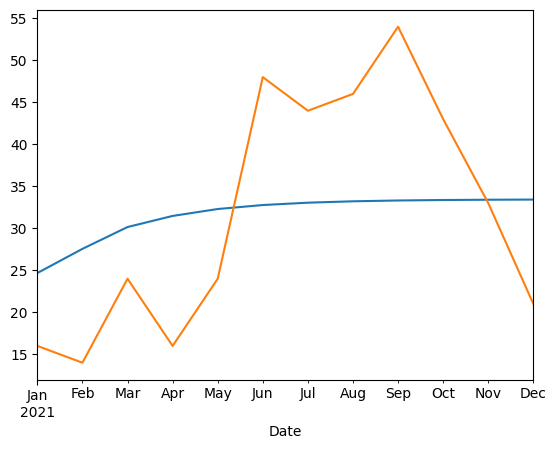

Alkoholunfälle and Verletzte und Getötete
11.20733672812064


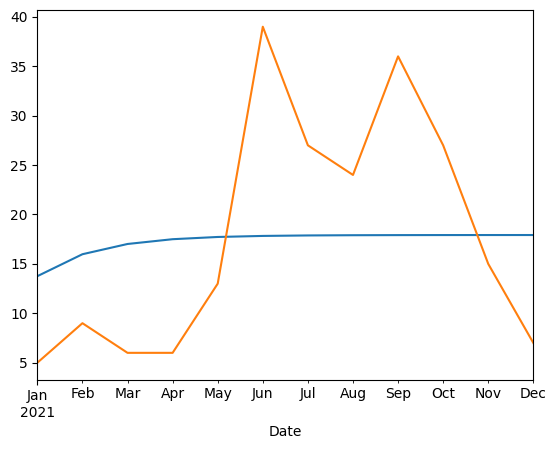

Fluchtunfälle and insgesamt
162.04003870113775


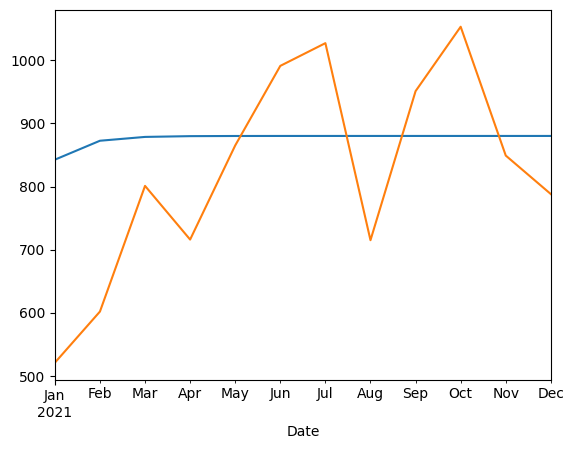

Fluchtunfälle and Verletzte und Getötete


/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


16.330702906031284


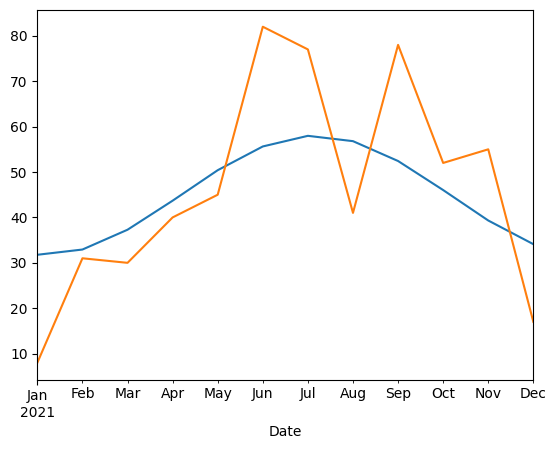

Verkehrsunfälle and insgesamt
580.6785456256507


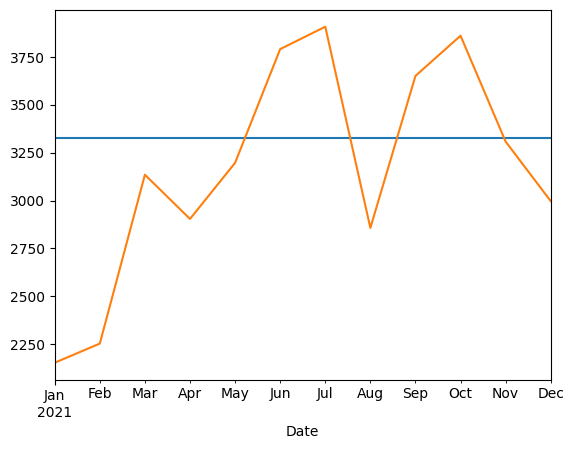

Verkehrsunfälle and mit Personenschäden


/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


74.4985649550213


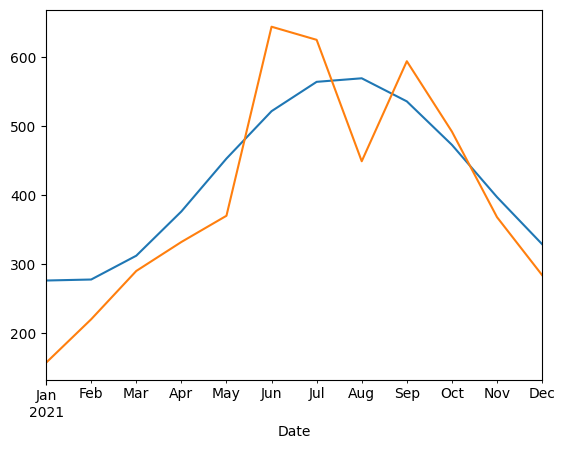

Verkehrsunfälle and Verletzte und Getötete


/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


98.90982717226241


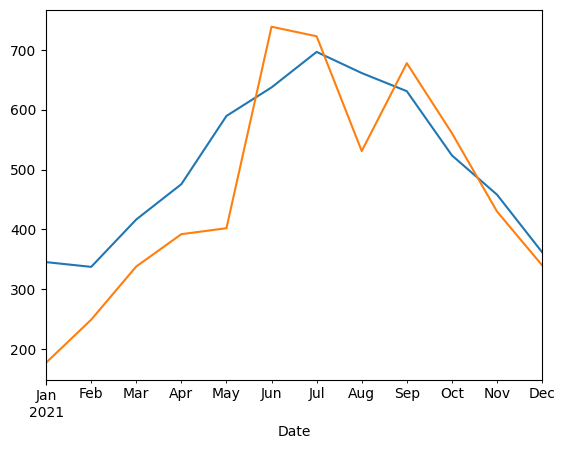

In [250]:
# Training & Testing model
best_params = [(2,1,1),(1,1,1),(1,1,1),(2,0,2),(0,1,1),(2,0,3),(3,0,4)]
best_params
for i in range(len(cols)):
    print(cols[i])
    model = ARIMA(df_new[cols[i]], order = best_params[i])
    model = model.fit()
#     display(model.summary())
#     pred = model.predict(n_periods=12)
    pred = model.predict(start = df_new.shape[0], end = df_new.shape[0] + test_df_new.shape[0] - 1, type='levels')
    pred.index = test_df_new.index
#     display(test_df_new[cols[i]])
#     display(pred)
    print(rmse(test_df_new[cols[i]], pred))
    pred.plot()
    test_df_new[cols[i]].plot()
    plt.show()

# Appendix

In [ ]:
# Going deeper into every accident-type
for acc in df_month['AUSPRAEGUNG'].unique():
    print(acc)
    sns.stripplot(data=df_month[df_month['AUSPRAEGUNG'] == acc], y='WERT', x='MONATSZAHL')
    plt.show()

In [ ]:
# Going deeper into every category
for cat in df_month['MONATSZAHL'].unique():
    print(cat)
    sns.stripplot(data=df_month[df_month['MONATSZAHL'] == cat], y='WERT', x='AUSPRAEGUNG')
    plt.show()

In [ ]:
# Line/Scatter plot total accidents in a year: Didn't give much insight
temp = df_year.copy()
temp['JAHR'] = temp['JAHR'].apply(lambda x: str(x)+'0101')
temp['JAHR'] = pd.to_datetime(temp['JAHR'])

sns.lineplot(data = temp, x = 'JAHR', y = 'WERT', hue='MONATSZAHL')
plt.show()
sns.scatterplot(data = temp, x = 'JAHR', y = 'WERT', hue='MONATSZAHL')
plt.show()

sns.lineplot(data = temp, x = 'JAHR', y = 'WERT', hue='AUSPRAEGUNG')
plt.show()
sns.scatterplot(data = temp, x = 'JAHR', y = 'WERT', hue='AUSPRAEGUNG')
plt.show()